In [273]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import geopy.distance

This notebook uses data relating to taxi fares in New York to build a regression model to predict taxi fares based on distance travelled, fare class and other features. The model uses Pytorch and is based on the course by Jose Portilla on Udemy. The original dataset has 55 million rows but this model uses just 120,000 rows.

https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

In [219]:
df = pd.read_csv('C:/Users/imoge/Projects/Datasets/NYCTaxiFares.csv')

In [220]:
df.shape

(120000, 8)

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


In [222]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [223]:
df.describe()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,10.040326,0.333333,-73.976626,40.751443,-73.974501,40.751695,1.347167
std,7.500134,0.471406,0.031497,0.025821,0.032419,0.030279,0.759263
min,2.500000,0.000000,-74.465447,40.121653,-74.443323,40.164927,1.000000
25%,5.700000,0.000000,-73.992386,40.736594,-73.991478,40.735914,1.000000
50%,7.700000,0.000000,-73.982084,40.753661,-73.980411,40.754441,1.000000
75%,11.300000,1.000000,-73.968710,40.768020,-73.965500,40.768880,1.000000
max,49.900000,1.000000,-73.311845,40.981292,-73.496140,40.993498,5.000000


The max fare is almost 50 dollars, the minimum 2.5 dollars and the mean around 10 dollars

### Longitude and Latitude to get distance measure

Need to use feature engineering to convert the longitude and latitude data to get useful information out of the data and feed into the neural network. 

In [224]:
# Function to calculate distance and apply to the dropoff and pickup latitudes and longitudes (uses the Haversine formula
# based on the earth being assumed to be a sphere)
def distancer(row):
    coords_1 = (row['pickup_longitude'], row['pickup_latitude'])
    coords_2 = (row['dropoff_longitude'], row['dropoff_latitude'])
    return geopy.distance.geodesic(coords_1, coords_2).km

df['distance'] = df.apply(distancer, axis=1)

In [225]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,1.932727
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.771932
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.832587
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2.166696
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,9.492877


In [226]:
df["distance"].describe()

count    120000.000000
mean          2.652620
std           3.472919
min           0.003143
25%           0.901845
50%           1.610695
75%           2.892851
max          31.642037
Name: distance, dtype: float64

The mean distance travelled is just under 3 km, with the maximum of 31 and minimum of 3 metres!

In [227]:
# Journeys less than 5 metres
df[df["distance"] < 0.005]

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
15376,2010-04-24 23:39:01 UTC,2.50,0,-74.005279,40.721473,-74.005307,40.721580,1,0.004539
33527,2010-04-15 20:38:41 UTC,2.50,0,-74.002357,40.726479,-74.002368,40.726573,1,0.003143
46019,2010-04-15 06:38:22 UTC,49.57,1,-73.980163,40.776280,-73.980179,40.776189,1,0.003325
46535,2010-04-22 07:49:32 UTC,14.90,1,-73.965577,40.755685,-73.965601,40.755786,2,0.004108
62056,2010-04-14 10:56:47 UTC,14.00,1,-73.993123,40.736208,-73.993147,40.736118,1,0.003854
88598,2010-04-22 21:57:57 UTC,5.70,0,-73.958604,40.773224,-73.958605,40.773083,1,0.004352


In [228]:
#df.drop(columns = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"], axis = 1, inplace = True)

In [229]:
# Get the datetime
# The data was saved in UTC time and is in April of 2010 during Daylight Savings Time in New York. 
# EDT is adjusted using UTC-4 (subtracting four hours).
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19])- pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head(2)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,1.932727,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.771932,2010-04-17 11:43:53,11,am,Sat


In [230]:
print(df['EDTdate'].min())
print(df['EDTdate'].max())

2010-04-11 00:00:10
2010-04-24 23:59:42


### Data Exploration and Visualisation

In [264]:
df.head(2)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,1.932727,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.771932,2010-04-17 11:43:53,11,am,Sat


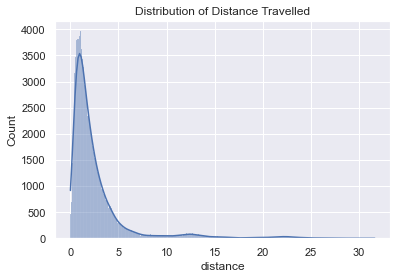

In [278]:
sns.histplot(data=df, x="distance", kde = True)
plt.title("Distribution of Distance Travelled");

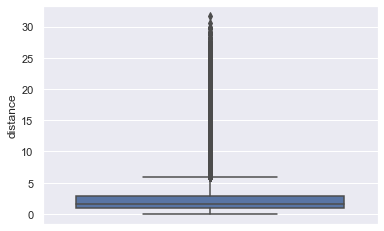

In [295]:
sns.boxplot(data = df, y = "distance");

Most distances travelled are below 5km. The distribution is positive skewed with a few outliers

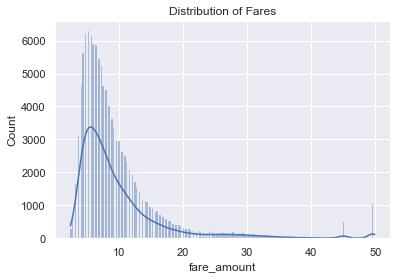

In [277]:
sns.histplot(df["fare_amount"],kde = True)
plt.title("Distribution of Fares");

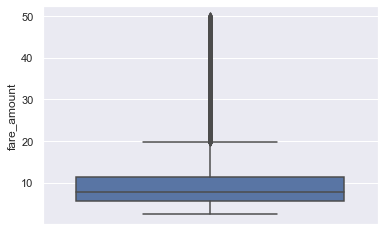

In [297]:
sns.boxplot(data = df, y = "fare_amount");

Most fares are below $20. The distribution is positive skewed with outliers

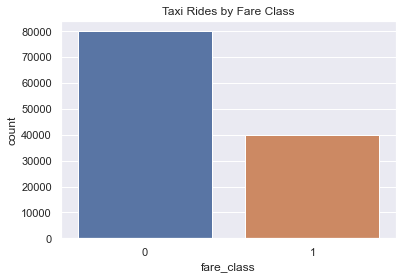

In [308]:
sns.countplot(data = df, x = "fare_class")
plt.title("Taxi Rides by Fare Class");

Fare class 0 is the most used.

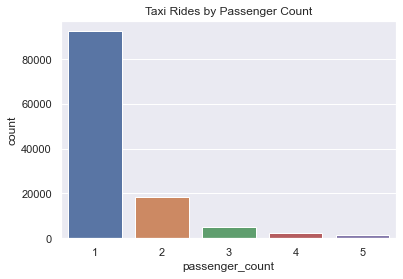

In [309]:
sns.countplot(data = df, x = "passenger_count")
plt.title("Taxi Rides by Passenger Count");

Most rides only contain one passenger

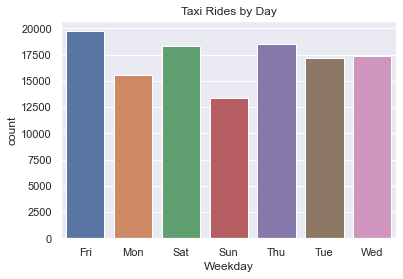

In [300]:
sns.countplot(data = df, x = "Weekday")
plt.title("Taxi Rides by Day");

The busiest day for taxis is Friday and Sunday the least busy

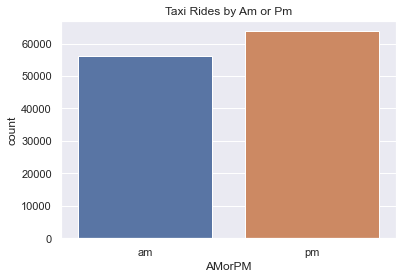

In [301]:
sns.countplot(data = df, x = "AMorPM")
plt.title("Taxi Rides by Am or Pm");

Most taxi rides are in the afternoon

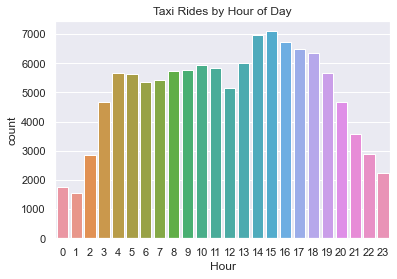

In [303]:
sns.countplot(data = df, x = "Hour")
plt.title("Taxi Rides by Hour of Day");

The busiest times of day for taxis are 2pm to 3pm and the least busy times are at midnight to 2am

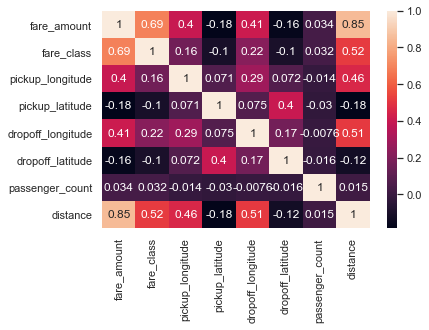

In [306]:
sns.heatmap(df.corr(), annot = True);

As expected the fare amount is most highly correlated with distance but also the fare class

### Categorical variables

In [231]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [232]:
# Some variables can be categorical or continuous (eg hour)
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'distance']
y = ['fare_amount'] # the label

In [233]:
# Convert category columns to category variable type
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   pickup_datetime    120000 non-null  object        
 1   fare_amount        120000 non-null  float64       
 2   fare_class         120000 non-null  int64         
 3   pickup_longitude   120000 non-null  float64       
 4   pickup_latitude    120000 non-null  float64       
 5   dropoff_longitude  120000 non-null  float64       
 6   dropoff_latitude   120000 non-null  float64       
 7   passenger_count    120000 non-null  int64         
 8   distance           120000 non-null  float64       
 9   EDTdate            120000 non-null  datetime64[ns]
 10  Hour               120000 non-null  category      
 11  AMorPM             120000 non-null  category      
 12  Weekday            120000 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(6

In [235]:
# Check one of the categories - weekday
df["Weekday"].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [236]:
# How the data is coded as numerical values
df["Weekday"].cat.codes

0         1
1         2
2         2
3         3
4         0
         ..
119995    3
119996    0
119997    3
119998    5
119999    2
Length: 120000, dtype: int8

In [237]:
# Check format is numpy array which can be transformed into tensors
df["Weekday"].cat.codes.values

array([1, 2, 2, ..., 3, 5, 2], dtype=int8)

In [238]:
# Convert the data into arrays which can be combined into one array
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1) # combine the variables into one stacked along columns (axis = 1)

cats[:3] # check the first few

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2]], dtype=int8)

Alternative to do the stacking:

* cats = np.stack([df[col].cat.codes.values for col in cat], 1)

In [239]:
# Convert to tensor
cats = torch.tensor(cats, dtype=torch.int64) # source data is an array, not an existing tensor so method used
cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [240]:
# Convert continuous variables to a combined tensor also
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   1.9327],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.7719],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.8326],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   2.1667],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   9.4929]])

In [241]:
# Convert labels to tensor
y = torch.tensor(df[y].values, dtype=torch.float).reshape(-1,1) # reshape not normally needed
y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [242]:
# Check the shapes
print(cats.shape, conts.shape, y.shape)

torch.Size([120000, 3]) torch.Size([120000, 6]) torch.Size([120000, 1])


### Set Embedding Sizes for categorical variables

Need to one-hot encode the categories (similar to text)

In [243]:
# Get the size of each category in a list form
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
cat_szs # returns the sizes of each category

[24, 2, 7]

In [244]:
# Get embedding sizes and compare to original size
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs] # divide the number of entries by 2 to a max of 50
emb_szs

[(24, 12), (2, 1), (7, 4)]

### Tabular Model for categorical and continuous variables

In [245]:
# Show the first few lines for the combined category tensor
cat_s = cats[:4]
cat_s

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [246]:
# Create a list of the embeddings
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [247]:
# Show the number and embedding tuple
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [248]:
# Show the forward pass using the sample of cats and show the embeddings
embedding_s = []
for i,e in enumerate(selfembeds):
    embedding_s.append(e(cat_s[:,i]))
embedding_s # the first embedding has 12 values, second has 1 and third has 4 for each of the records

[tensor([[-2.1542,  0.4625, -0.5621,  0.0071, -0.5269,  1.5625, -0.0076, -2.0026,
          -1.0037, -0.2262, -1.0735,  0.1780],
         [ 1.5201, -0.7800, -0.4537, -0.2299, -0.3341, -0.0109, -0.3055, -0.6463,
          -0.0596, -0.2988, -0.0036, -2.1355],
         [-0.8487,  0.5008, -0.1591,  0.5427,  0.2948, -2.3019,  1.0795,  1.1491,
          -0.6258, -0.6934,  0.4639,  0.7618],
         [-0.1616, -1.3367,  0.9629,  0.5754, -0.7234,  1.7538, -0.1694, -0.3735,
          -0.3570,  0.1229, -0.2899,  0.6967]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.5767],
         [-0.5767],
         [-0.5767],
         [ 0.1685]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.7358,  0.6393,  0.4692,  0.1078],
         [-0.6573, -1.2984, -1.0163, -1.3583],
         [-0.6573, -1.2984, -1.0163, -1.3583],
         [-0.5922, -0.8466, -0.2559,  0.7167]], grad_fn=<EmbeddingBackward0>)]

In [249]:
# The third embedding has four values as per emb_szs
embedding_s[2]

tensor([[-0.7358,  0.6393,  0.4692,  0.1078],
        [-0.6573, -1.2984, -1.0163, -1.3583],
        [-0.6573, -1.2984, -1.0163, -1.3583],
        [-0.5922, -0.8466, -0.2559,  0.7167]], grad_fn=<EmbeddingBackward0>)

In [250]:
# Concat the embeddings into one tensor embedding with 17 values
comb = torch.cat(embedding_s, 1)
comb

tensor([[-2.1542,  0.4625, -0.5621,  0.0071, -0.5269,  1.5625, -0.0076, -2.0026,
         -1.0037, -0.2262, -1.0735,  0.1780, -0.5767, -0.7358,  0.6393,  0.4692,
          0.1078],
        [ 1.5201, -0.7800, -0.4537, -0.2299, -0.3341, -0.0109, -0.3055, -0.6463,
         -0.0596, -0.2988, -0.0036, -2.1355, -0.5767, -0.6573, -1.2984, -1.0163,
         -1.3583],
        [-0.8487,  0.5008, -0.1591,  0.5427,  0.2948, -2.3019,  1.0795,  1.1491,
         -0.6258, -0.6934,  0.4639,  0.7618, -0.5767, -0.6573, -1.2984, -1.0163,
         -1.3583],
        [-0.1616, -1.3367,  0.9629,  0.5754, -0.7234,  1.7538, -0.1694, -0.3735,
         -0.3570,  0.1229, -0.2899,  0.6967,  0.1685, -0.5922, -0.8466, -0.2559,
          0.7167]], grad_fn=<CatBackward0>)

In [251]:
# Check example
comb[1]

tensor([ 1.5201, -0.7800, -0.4537, -0.2299, -0.3341, -0.0109, -0.3055, -0.6463,
        -0.0596, -0.2988, -0.0036, -2.1355, -0.5767, -0.6573, -1.2984, -1.0163,
        -1.3583], grad_fn=<SelectBackward0>)

In [252]:
# Now pass through a dropout layer to get the assigned values (randomly zeros some of the elements of the tensor -
# 40% neurons switched off)
selfembdrop = nn.Dropout(.4)
comb = selfembdrop(comb)
comb 

tensor([[-0.0000,  0.7708, -0.0000,  0.0119, -0.8782,  2.6042, -0.0000, -3.3376,
         -0.0000, -0.3769, -0.0000,  0.0000, -0.9612, -1.2263,  0.0000,  0.7820,
          0.1796],
        [ 0.0000, -0.0000, -0.7562, -0.3831, -0.0000, -0.0182, -0.0000, -1.0772,
         -0.0993, -0.0000, -0.0060, -0.0000, -0.0000, -1.0955, -0.0000, -0.0000,
         -0.0000],
        [-0.0000,  0.0000, -0.2652,  0.9044,  0.0000, -0.0000,  1.7992,  1.9152,
         -0.0000, -1.1557,  0.0000,  1.2697, -0.9612, -0.0000, -2.1640, -1.6939,
         -0.0000],
        [-0.0000, -2.2278,  1.6048,  0.9590, -1.2056,  0.0000, -0.2823, -0.6226,
         -0.5950,  0.0000, -0.4832,  1.1612,  0.2809, -0.9870, -0.0000, -0.4266,
          1.1944]], grad_fn=<MulBackward0>)

In [253]:
# Look at example - note some values are zeroed
comb[1]

tensor([ 0.0000, -0.0000, -0.7562, -0.3831, -0.0000, -0.0182, -0.0000, -1.0772,
        -0.0993, -0.0000, -0.0060, -0.0000, -0.0000, -1.0955, -0.0000, -0.0000,
        -0.0000], grad_fn=<SelectBackward0>)

### Create the full model

In [254]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5): # input embedding sizes, number of features, output and droput prob
        super().__init__()                                      # instantiate inherited class
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs]) # create the embeddings
        self.emb_drop = nn.Dropout(p)                                            # apply dropout
        self.bn_cont = nn.BatchNorm1d(n_cont)                                    # normalize data function
        
        layerlist = []   
        n_emb = sum((nf for ni,nf in emb_szs))   # get total number of embeddings
        n_in = n_emb + n_cont                    # total number of embeddings and the number of continuous features
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))  # set up layers - linear layer with n number of inputs
            layerlist.append(nn.ReLU(inplace=True))  # add the activation function RELU
            layerlist.append(nn.BatchNorm1d(i))      # append the normalisation process
            layerlist.append(nn.Dropout(p))          # append a dropout
            n_in = i                                 
        layerlist.append(nn.Linear(layers[-1],out_sz))  
            
        self.layers = nn.Sequential(*layerlist) # combine the layers here
    
    def forward(self, x_cat, x_cont): # process embeddings and normalize continous. 
        embeddings = []
        for i,e in enumerate(self.embeds): 
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)   
        x = self.emb_drop(x)           # apply dropout
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [255]:
# input the embedding sizes, num of continuous variables, neurons in each layer and the dropout 
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4) 

In [256]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

### Loss function and optimizer

In [257]:
criterion = nn.MSELoss()  # mean-squared loss 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #optimizer Adam and learning rate

In [258]:
# Set batch size and train test seizes
batch_size = 60000 # two batches of 60000 = 120000 total
test_size = int(batch_size * .2) 

cat_train = cats[:batch_size-test_size] # split the categorical and continuous training and tests as they are separate
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [259]:
print(len(cat_train),len(cat_test), len(y_train), len(y_test))

48000 12000 48000 12000


### Train the model

In [260]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss.item())
    
    # report results every 25 epochs
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.57388973
epoch:  26  loss: 11.04904270
epoch:  51  loss: 10.38323307
epoch:  76  loss: 9.84527588
epoch: 101  loss: 9.20498657
epoch: 126  loss: 8.37561798
epoch: 151  loss: 7.31317806
epoch: 176  loss: 6.12122822
epoch: 201  loss: 4.94194603
epoch: 226  loss: 4.16422510
epoch: 251  loss: 3.85492158
epoch: 276  loss: 3.74076605
epoch: 300  loss: 3.70495343

Duration: 44 seconds


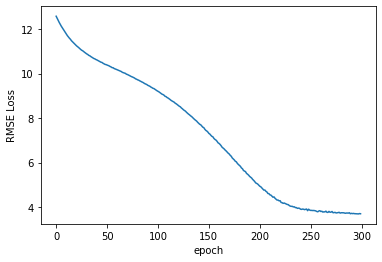

In [261]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [262]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.63235283


In [263]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.2f} {y_test[i].item():8.2f} {diff:8.2f}')

   PREDICTED   ACTUAL     DIFF
 1.     4.37     2.90     1.47
 2.    14.28     5.70     8.58
 3.     6.08     7.70     1.62
 4.    16.08    12.50     3.58
 5.     6.33     4.10     2.23
 6.     5.02     5.30     0.28
 7.     3.35     3.70     0.35
 8.    20.58    14.50     6.08
 9.     8.52     5.70     2.82
10.    12.93    10.10     2.83
11.     8.08     4.50     3.58
12.     2.94     6.10     3.16
13.     6.58     6.90     0.32
14.     8.76    14.10     5.34
15.     4.88     4.50     0.38
16.    29.19    34.10     4.91
17.     3.23    12.50     9.27
18.     5.80     4.10     1.70
19.     8.08     8.50     0.42
20.     6.62     5.30     1.32
21.    13.44    11.30     2.14
22.    11.36    10.50     0.86
23.    15.38    15.30     0.08
24.    16.51    14.90     1.61
25.    48.54    49.57     1.03
26.     1.62     5.30     3.68
27.     4.63     3.70     0.93
28.     5.28     6.50     1.22
29.    13.47    14.10     0.63
30.     5.66     4.90     0.76
31.     3.83     3.70     0.13
32.    3

Model analysis - the model performed fairly well on many of the test data items but in some cases the prediction was very different from the actual fare. There may be many reasons for this so further work would be needed to refine the model to see if the predictions could be improved.